In [1]:
import pandas as pd
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## EDA

In [2]:
df = pd.read_csv('TEST TASK (dataset).csv')
df.head(5)

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.000000000,1.000000000,1.000000000,1.000000000,0,0,0,0,0,0,...,2021-12-03,COUNTRY_135,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
1,1.000000000,1.000000000,1.000000000,1.000000000,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
2,1.000000000,2.000000000,2.000000000,2.000000000,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
3,1.000000000,1.000000000,1.000000000,1.000000000,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
4,1.000000000,1.000000000,1.000000000,1.000000000,0,0,0,0,0,0,...,2021-12-03,COUNTRY_203,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000


In [3]:
# Аналіз повної цільової метрики
df.target_full_ltv_day30.describe()

count   1467832.000000000
mean          0.256872849
std           2.274466098
min          -2.777195259
25%           0.000000000
50%           0.000000000
75%           0.000000000
max         272.004211814
Name: target_full_ltv_day30, dtype: float64

In [4]:
# Аналіз метрики внутрішньоігрових транзакцій
df.target_iap_ltv_day30.describe()

count   1467832.000000000
mean          0.213926754
std           2.097915601
min           0.000000000
25%           0.000000000
50%           0.000000000
75%           0.000000000
max         268.787759321
Name: target_iap_ltv_day30, dtype: float64

In [5]:
df.target_sub_ltv_day30.describe()

count   1467832.000000000
mean          0.022030373
std           0.308875777
min          -2.829603837
25%           0.000000000
50%           0.000000000
75%           0.000000000
max          45.457412416
Name: target_sub_ltv_day30, dtype: float64

In [6]:
# Відсоток гравців, які принесли якийсь прибуток
df[df.target_full_ltv_day30 > 0].shape[0] / df[df.target_full_ltv_day30 <= 0].shape[0] * 100

30.527326729151476

In [7]:
# Відсоток гравців, у яких за 0 день кількість сесій >= 100
df[df.total_sessions_day7 >= 100].shape[0] / df[df.total_sessions_day7 < 100].shape[0] * 100

0.10252867662919568

In [8]:
# Аналіз людей, які мають дуже велику кількість отриманих кристалів за 7 днів
df[df.diamonds_received_day7 > 15000]

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
11372,3.000000000,4.000000000,7.000000000,8.000000000,0,2,3,3,1,2,...,2021-12-07,COUNTRY_210,0.003401568,0.003401568,0.003401568,android,0.000000000,0.000000000,0.003401568,0.003401568
17342,2.000000000,2.000000000,2.000000000,2.000000000,0,0,0,0,2,2,...,2021-12-02,COUNTRY_72,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
23230,1.000000000,1.000000000,1.000000000,1.000000000,0,0,0,0,1,1,...,2021-12-08,COUNTRY_52,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
27305,5.000000000,10.000000000,24.000000000,25.000000000,5,13,26,32,7,15,...,2021-12-08,COUNTRY_21,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
32508,2.000000000,7.000000000,13.000000000,13.000000000,7,10,11,11,7,12,...,2021-12-06,COUNTRY_211,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
32622,8.000000000,14.000000000,17.000000000,17.000000000,5,10,15,15,7,12,...,2021-12-06,COUNTRY_203,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
499665,1.000000000,1.000000000,1.000000000,1.000000000,0,0,0,0,1,1,...,2021-12-18,COUNTRY_155,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
507802,10.000000000,25.000000000,36.000000000,50.000000000,3,8,20,32,4,10,...,2021-12-18,COUNTRY_155,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
560612,2.000000000,2.000000000,2.000000000,2.000000000,0,0,0,0,1,1,...,2021-12-20,COUNTRY_141,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.027562629,0.027562629
567908,771.000000000,771.000000000,771.000000000,771.000000000,7,359,360,360,10,360,...,2021-12-20,COUNTRY_141,0.273079751,19.748999279,19.970615370,android,8.401217263,174.796486298,22.814450194,206.012153754


### Можна помітити, що у нас є деякі від'ємні мінімальні значення у фічах target_sub_ltv_day30 та target_full_ltv_day30, яка включає її в себе
### Тому логічним кроком було б видалити цей викид

In [9]:
df = df[df.target_full_ltv_day30 >= 0.0]

In [10]:
# Всі рядки з хоча б 1 NaN значенням у стовбці
df[df.isna().any(axis=1)]

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
29,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
52,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,2021-12-03,COUNTRY_72,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
99,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
130,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
222,NaN,NaN,NaN,NaN,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448245,NaN,NaN,NaN,NaN,0,0,0,0,1,1,...,2021-12-30,COUNTRY_137,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
1448246,NaN,NaN,NaN,NaN,0,0,0,0,1,1,...,2021-12-30,COUNTRY_137,0.000000000,0.000000000,0.000000000,android,0.000000000,0.000000000,0.000000000,0.000000000
1448787,NaN,NaN,NaN,NaN,0,0,0,0,1,1,...,2021-12-30,COUNTRY_208,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000
1451375,NaN,NaN,NaN,NaN,1,1,1,1,2,2,...,2021-12-30,COUNTRY_141,0.000000000,0.000000000,0.000000000,ios,0.000000000,0.000000000,0.000000000,0.000000000


### Всього 1374 рядка з пропущеними значеннями у total_sessions_day{N}
### Так як це менше 0.1% даних, тому можна знехтувати ними

In [11]:
# видаляємо рядки з пропущеними значеннями 
df.dropna(axis='rows', inplace=True)

In [12]:
# подивимося на типи даних стовбців
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466457 entries, 0 to 1467831
Data columns (total 63 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   total_sessions_day0         1466457 non-null  float64
 1   total_sessions_day1         1466457 non-null  float64
 2   total_sessions_day3         1466457 non-null  float64
 3   total_sessions_day7         1466457 non-null  float64
 4   chapters_finished_day0      1466457 non-null  int64  
 5   chapters_finished_day1      1466457 non-null  int64  
 6   chapters_finished_day3      1466457 non-null  int64  
 7   chapters_finished_day7      1466457 non-null  int64  
 8   chapters_opened_day0        1466457 non-null  int64  
 9   chapters_opened_day1        1466457 non-null  int64  
 10  chapters_opened_day3        1466457 non-null  int64  
 11  chapters_opened_day7        1466457 non-null  int64  
 12  chapters_closed_day0        1466457 non-null  int64  
 1

### Фічі, які є об'єктами - platform, media_source, install_date, country_code 
#### Подивимося на них

In [13]:
df[['platform', 'media_source', 'install_date', 'country_code']]

,platform,media_source,install_date,country_code
0,ios,SOURCE_23,2021-12-03,COUNTRY_135
1,android,SOURCE_2,2021-12-03,COUNTRY_141
2,android,SOURCE_17,2021-12-03,COUNTRY_141
3,ios,SOURCE_23,2021-12-03,COUNTRY_141
4,android,SOURCE_1,2021-12-03,COUNTRY_203
...,...,...,...,...
1467827,ios,SOURCE_17,2021-12-30,COUNTRY_141
1467828,ios,SOURCE_23,2021-12-30,COUNTRY_141
1467829,ios,SOURCE_23,2021-12-30,COUNTRY_141
1467830,ios,SOURCE_4,2021-12-30,COUNTRY_141


### Застосуємо Label Encoding на них

In [14]:
def encode_labels(df):
    le = LabelEncoder()
    df.platform = le.fit_transform(df.platform.values)
    platform_dict = dict(zip(le.classes_, range(len(le.classes_))))
    
    # файл кодувань платформ
    with open(file='platforms_label_dict.json', mode='w', encoding='utf-8') as file:
        json.dump(platform_dict, file)
        
    le = LabelEncoder()
    df.country_code = le.fit_transform(df.country_code.values)
    country_dict = dict(zip(le.classes_, range(len(le.classes_))))
    
    # файл кодувань країн
    with open(file='country_label_dict.json', mode='w', encoding='utf-8') as file:
        json.dump(country_dict, file)
    
    le = LabelEncoder()
    df.media_source = le.fit_transform(df.media_source.values)
    
    # файл кодувань джерела інформації
    media_source_dict = dict(zip(le.classes_, range(len(le.classes_))))
    with open(file='media_source_dict.json', mode='w', encoding='utf-8') as file:
        json.dump(media_source_dict, file)

    # ці файли потрібні вже під час використання готової моделі щоб кодування даних співпадало з тренувальним
        
    return df

In [15]:
df = encode_labels(df)

In [16]:
# переведемо 'str' дату до datetime64 та отримаємо фічі року, місяця, дня, та дня неділі
df['install_date'] = pd.to_datetime(df['install_date'], format='%Y-%m-%d')
df['year'] = df.install_date.dt.year
df['month'] = df.install_date.dt.month
df['day'] = df.install_date.dt.day
df['day_of_week'] = df.install_date.dt.day_of_week
df.drop(columns=['install_date'], inplace=True)

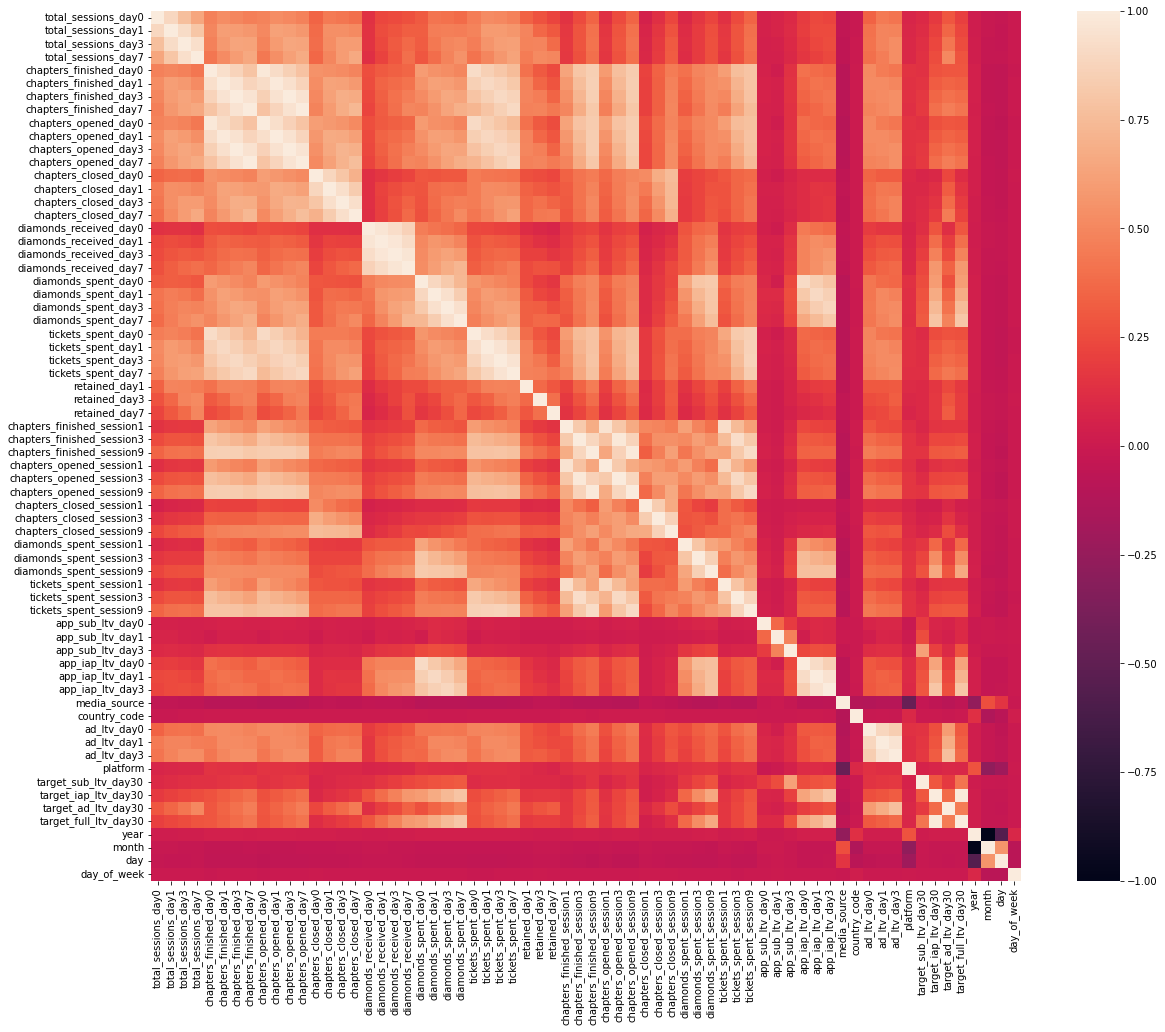

In [17]:
# Кореляційна матриця
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(corrmat, vmax=1, square=True);

### Виходячи з кореляційної матриці подивимося на найцікавіші фічі та їх залежності відносно target_full_ltv_day30

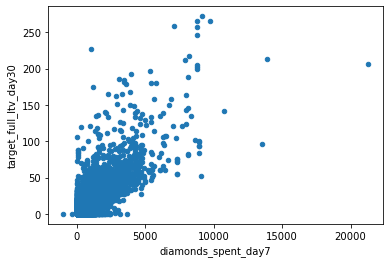

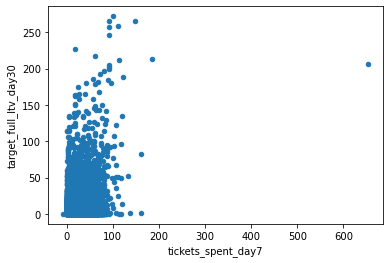

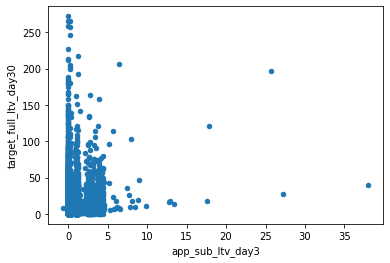

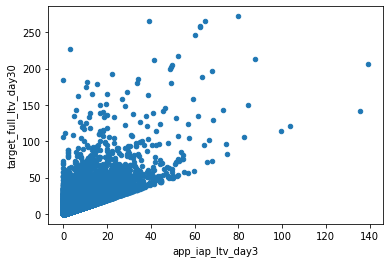

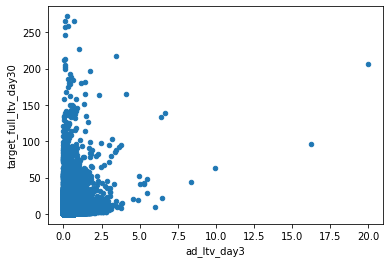

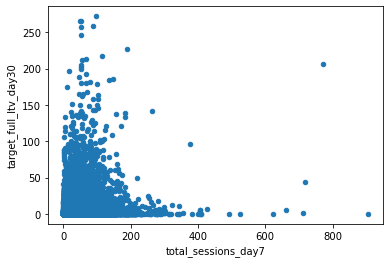

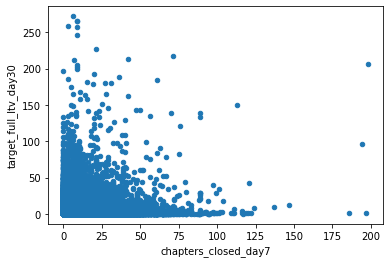

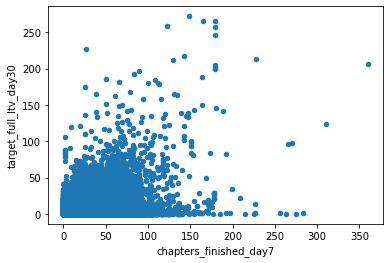

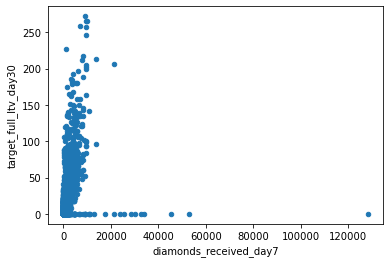

In [18]:
columns = ['diamonds_spent_day7', 'tickets_spent_day7', 'app_sub_ltv_day3', 'app_iap_ltv_day3',
           'ad_ltv_day3',  'total_sessions_day7', 'chapters_closed_day7', 
           'chapters_finished_day7', 'diamonds_received_day7']

for column in columns:
    data = pd.concat([df['target_full_ltv_day30'], df[column]], axis=1)
    data.plot.scatter(x=column, y='target_full_ltv_day30')

### Деякі фічі неповністю розкриваються, тому застосуємо $np.log(1 + x)$ на наших фічах

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


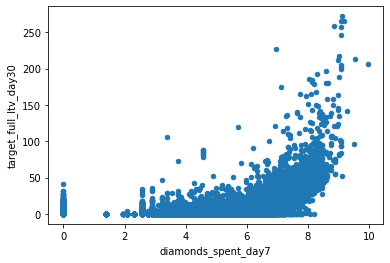

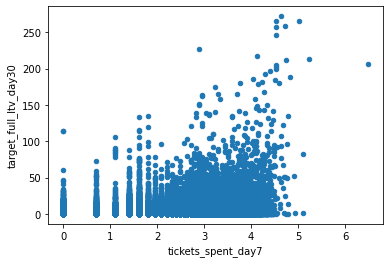

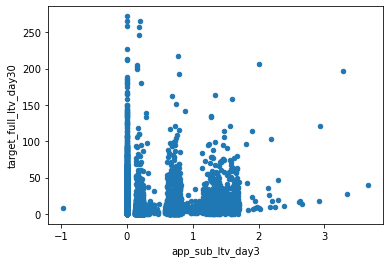

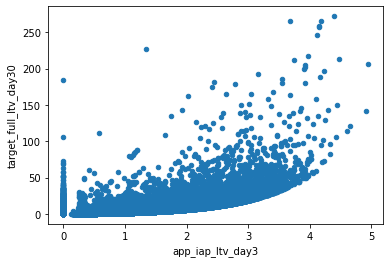

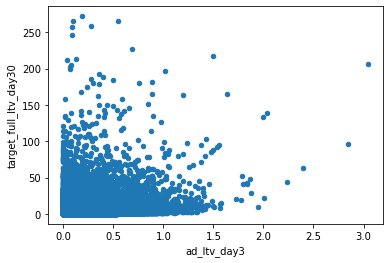

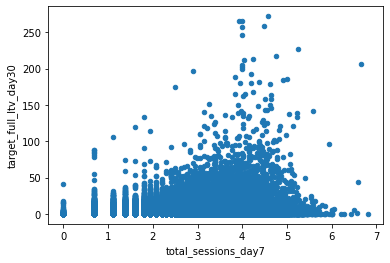

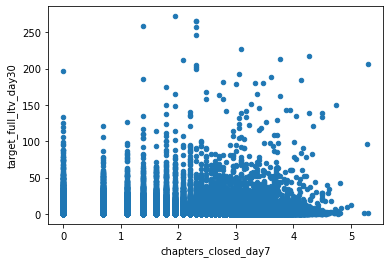

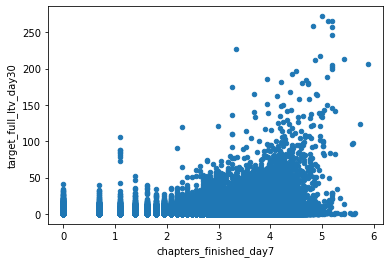

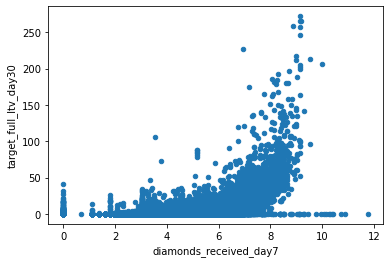

In [19]:
columns = ['diamonds_spent_day7', 'tickets_spent_day7', 'app_sub_ltv_day3', 'app_iap_ltv_day3',
           'ad_ltv_day3',  'total_sessions_day7', 'chapters_closed_day7', 
           'chapters_finished_day7', 'diamonds_received_day7']

for column in columns:
    data = pd.concat([df['target_full_ltv_day30'], np.log(df[column] + 1)], axis=1)
    data.plot.scatter(x=column, y='target_full_ltv_day30')

In [20]:
# функція для створення MI SCORES
def make_mi_scores(X, y):
    X = X.copy()
    # вибираємо дискретні фічі та створюємо MI SCORE
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [21]:
# обираємо 100.000 рандомних прикладів щоб MI SCORE швидше відпрацював
temp_df = df.sample(n=100000)
Y_temp = temp_df['target_full_ltv_day30']
X_temp = temp_df.drop(columns=['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30', 'target_full_ltv_day30'])
mi_scores = make_mi_scores(X_temp, Y_temp)
print(mi_scores.to_string())

ad_ltv_day3                  1.164111374
ad_ltv_day1                  1.012936665
ad_ltv_day0                  0.889075858
diamonds_received_day7       0.413469605
diamonds_received_day3       0.402561726
diamonds_spent_session9      0.391125084
diamonds_received_day1       0.383176429
diamonds_spent_day7          0.365787359
diamonds_spent_day3          0.356924698
diamonds_received_day0       0.355762640
diamonds_spent_day1          0.338667630
chapters_finished_session9   0.330978589
chapters_finished_day7       0.327392465
chapters_opened_session9     0.321785728
chapters_opened_day7         0.318115718
diamonds_spent_day0          0.311055619
chapters_finished_day3       0.309370427
tickets_spent_session9       0.303945373
diamonds_spent_session3      0.303620432
tickets_spent_day7           0.302470694
chapters_opened_day3         0.299277566
app_iap_ltv_day3             0.288752608
tickets_spent_day3           0.285226359
chapters_finished_day1       0.283945873
chapters_opened_

### На основі кореляційної матриці, MI scores, та графіків можна зробити висновок, що варто зробити інтеракцію фіч між diamonds_spent_day{N}, app_sub_ltv_day{N}, app_iap_ltv_day{N}, ad_ltv_day{N}, tickets_spent_day{N}

In [22]:
def feature_interaction(df):
    # пробуємо різну комбінацію фіч
    df['diamond_spent_diff_7_0'] = df['diamonds_spent_day7'] - df['diamonds_spent_day0']
    df['diamond_spent_diff_7_1'] = df['diamonds_spent_day7'] - df['diamonds_spent_day1']
    df['diamond_spent_diff_7_3'] = df['diamonds_spent_day7'] - df['diamonds_spent_day3']
    df['diamond_spent_ratio_7_0'] = df['diamonds_spent_day7'] / df['diamonds_spent_day0']
    df['diamond_spent_ratio_7_1'] = df['diamonds_spent_day7'] / df['diamonds_spent_day1']
    df['diamond_spent_ratio_7_3'] = df['diamonds_spent_day7'] / df['diamonds_spent_day3']
    df['diamond_spent_sum_7_3'] = df['diamonds_spent_day7'] + df['diamonds_spent_day3']
    df['diamond_spent_diff_3_0'] = df['diamonds_spent_day3'] - df['diamonds_spent_day0']
    df['diamond_spent_diff_3_1'] = df['diamonds_spent_day3'] - df['diamonds_spent_day1']
    df['diamond_spent_ratio_3_0'] = df['diamonds_spent_day3'] / df['diamonds_spent_day0']
    df['diamond_spent_ratio_3_1'] = df['diamonds_spent_day3'] / df['diamonds_spent_day1']
    df['diamond_spent_diff_1_0'] = df['diamonds_spent_day1'] - df['diamonds_spent_day0']
    df['diamond_spent_ratio_1_0'] = df['diamonds_spent_day1'] / df['diamonds_spent_day0']
    df['target_full_day3'] = df['app_sub_ltv_day3'] + df['app_iap_ltv_day3'] + df['ad_ltv_day3']
    df['target_iap_sub_ratio'] = df['app_iap_ltv_day3'] / df['app_sub_ltv_day3']
    df['target_sub_ltv_ratio'] = df['app_sub_ltv_day3'] / df['ad_ltv_day3']
    
    df['tickets_spent_diff_7_3'] = df['tickets_spent_day7'] - df['tickets_spent_day3']
    df['tickets_spent_ratio_7_3'] = df['tickets_spent_day7'] / df['tickets_spent_day3']
    
    df['app_iap_ltv_diamonds_spent_ratio_3'] = df['app_iap_ltv_day3'] / df['diamonds_spent_day3']

    df['diamonds_spent_app_iap_ltv_ratio_0'] = df['diamonds_spent_day0'] / df['app_iap_ltv_day0']
    
    df['diamond_spent_tickets_spent_ratio_7_3'] = df['tickets_spent_ratio_7_3'] / df['diamond_spent_ratio_7_3']
    
    df['app_iap_ltv_diff_1_3'] = df['app_iap_ltv_day1'] - df['app_iap_ltv_day3']
    df['app_iap_ltv_diff_0_3'] = df['app_iap_ltv_day0'] - df['app_iap_ltv_day3'] 
    
    income_columns = ['app_sub_ltv_day0', 'app_sub_ltv_day1', 'app_sub_ltv_day3', 
                  'app_iap_ltv_day0', 'app_iap_ltv_day1', 'app_iap_ltv_day3']

    df['is_profitable'] = (df[income_columns].sum(axis=1) > 0).astype(np.int32)
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    return df

In [23]:
df = feature_interaction(df)

In [24]:
# функція для оптимізації типів даних
def downcast_dtypes(df):
    float32_cols = [c for c in df if df[c].dtype == 'float64']
    int32_cols = [c for c in df if df[c].dtype in ['int64', 'int16', 'int8']]

    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols] = df[int32_cols].astype(np.int32)

    return df

In [25]:
df = downcast_dtypes(df)

In [26]:
# функція для розбиття даних на тренувальний та тестовий набори
def split_data(df):
    Y = df['target_full_ltv_day30']
    X = df.drop(columns=['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30', 'target_full_ltv_day30'])
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = split_data(df)
# скейлимо датасет
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Зберігаємо mean, var параметри scaler'y для подальшого використання
joblib.dump(scaler, 'scaler_data.sav')

Train = xgb.DMatrix(X_train, y_train)
Test = xgb.DMatrix(X_test, y_test)

### Оскільки xgboost найкраще підходить саме для задач з табличними даними, то ми вирішили використати його
### Параметри були отримані методом простого підбору. Далі можна запустити різні оптимайзери, як наприклад RandomizedSearchCV з sklearn, або HYPEROPT. 
### Ми не робили цього в нашому випадку задля зосередження на інших деталях.

In [28]:
xgb_params = {
    'n_gpus': 1,
    'tree_method': 'gpu_hist',
    'booster': 'gbtree',
    'eval_metric': 'mae',
    'lambda': '0.17', 
    'gamma': '0.125', 
    'alpha': '0.17',
    'colsample_bytree': '0.715',
    'subsample': '0.875', 
    'silent': True,
    'min_child_weight': 9,
    'eta': '0.15',
    'max_depth': 6,
    'seed': 3
}

In [29]:
# модель з RMSE
xgb_params['eval_metric'] = 'rmse'
model = xgb.train(xgb_params, Train, 500, [(Train, 'Train'), (Test, 'Test')], early_stopping_rounds=10, verbose_eval=1)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[16:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Train-rmse:2.04238	Test-rmse:1.88603
[1]	Train-rmse:1.82441	Test-rmse:1.68394
[2]	Train-rmse:1.65102	Test-rmse:1.52477
[3]	Train-rmse:1.50832	Test-rmse:1.38568
[4]	Train-rmse:1.38185	Test-rmse:1.27843
[5]	Train-rmse:1.28131	Test-rmse:1.19826
[6]	Train-rmse:1.19764	Test-rmse:1.13145
[7]	Train-rmse:1.13395	Test-rmse:1.08231
[8]	Train-rmse:1.08145	Test-rmse:1.04893
[9]	Train-rmse:1.03550	Test-rmse:1.02526
[10]	Train-rmse:1.00249	Test-rmse:1.00337
[11]	Train-rmse:0.97400	Test-rmse:0.99042
[12]	Train-rmse:0.95203	Test-rmse:0.98073
[13]	Train-rmse:0.93233	Test-rmse:0.971

In [30]:
# модель з MAPE
# додали 1e-4 для роботи MAPE, адже MAPE не працює, коли y_true може бути 0, адже відбувається ділення 0
# що є невизначеною операцією та MAPE повертає inf. 
xgb_params['eval_metric'] = 'mape'
model = xgb.train(xgb_params, Train, 500, [(xgb.DMatrix(X_train + 1e-4, y_train + 1e-4), 'Train'), (xgb.DMatrix(X_test + 1e-4, y_test + 1e-4), 'Test')], early_stopping_rounds=10, verbose_eval=1)

[16:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Train-mape:3291.67455	Test-mape:3290.30726
[1]	Train-mape:2811.60151	Test-mape:2810.33425
[2]	Train-mape:2398.65762	Test-mape:2397.53409
[3]	Train-mape:2056.27706	Test-mape:2055.19972
[4]	Train-mape:1760.43353	Test-mape:1759.32510
[5]	Train-mape:1505.65488	Test-mape:1504.57672
[6]	Train-mape:1288.37315	Test-mape:1287.30133
[7]	Train-mape:1099.45533	Test-mape:1098.30414
[8]	Train-mape:941.79897	Test-mape:940.75605
[9]	Train-mape:809.93313	Test-mape:808.94354
[10]	Train-mape:695.32962	Test-mape:694.36064
[11]	Train-mape:597.18813	Test-mape:596.19399
[12]	Train-mape:5

In [31]:
# модель з MAE
xgb_params['eval_metric'] = 'mae'
model = xgb.train(xgb_params, Train, 500, [(Train, 'Train'), (Test, 'Test')], early_stopping_rounds=10, verbose_eval=1)

[16:22:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_gpus", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Train-mae:0.58795	Test-mae:0.58224
[1]	Train-mae:0.50497	Test-mae:0.49974
[2]	Train-mae:0.43524	Test-mae:0.43038
[3]	Train-mae:0.37622	Test-mae:0.37158
[4]	Train-mae:0.32583	Test-mae:0.32177
[5]	Train-mae:0.28433	Test-mae:0.28070
[6]	Train-mae:0.24898	Test-mae:0.24568
[7]	Train-mae:0.21964	Test-mae:0.21636
[8]	Train-mae:0.19567	Test-mae:0.19275
[9]	Train-mae:0.17611	Test-mae:0.17388
[10]	Train-mae:0.16002	Test-mae:0.15807
[11]	Train-mae:0.14647	Test-mae:0.14494
[12]	Train-mae:0.13589	Test-mae:0.13482
[13]	Train-mae:0.12694	Test-mae:0.12614
[14]	Train-mae:0.11970	Te

#### З отриманих результатів тренування можна зробити висновок, що отриманий результат для тестового набору не є найкращим, адже ще є багато варіантів щодо покращення оцінки. Можна зробити більше інтеракцій між фічами, додатково обробити дані, створити якісь нові фічі та протюнити гіперпараметри моделі.
#### Стосовно моделі з MAE можна сказати, що рівень перевивчення не значний, але можна спробувати його зменшити за допомогою того ж тюнінга моделі. 
#### Стосовно моделі з RMSE можна сказати, те що викиди дійсно достатньо впливають на метрику, завдяки чому можна бачити явну різницю між тренувальним та тестовим наборами даних, а перевивчення є проблемою. 
#### Стосовно моделі з MAPE нічого сказати, вона не підходить під нашу задачу.

#### Але у всіх моделях можна помітити, те що кількість ітерацій маленька - максимально ~143 ітерації для моделі з MAE. Це пов'язано з тим, те що модель достатньо швидко перестає робити прогрес на тестовому наборі даних та після 10 ітерацій спрацьовує рання зупинка для недопущення перевивчення моделі. Ми гадаємо, що цю ситуацію можна трохи виправити, ретельно підібравши гіперпараметри моделі.

In [32]:
# функція побудови графіку з важливостями фіч
def plot_features_importance(booster, figsize):    
    fig, ax = plt.subplots(1,1, figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

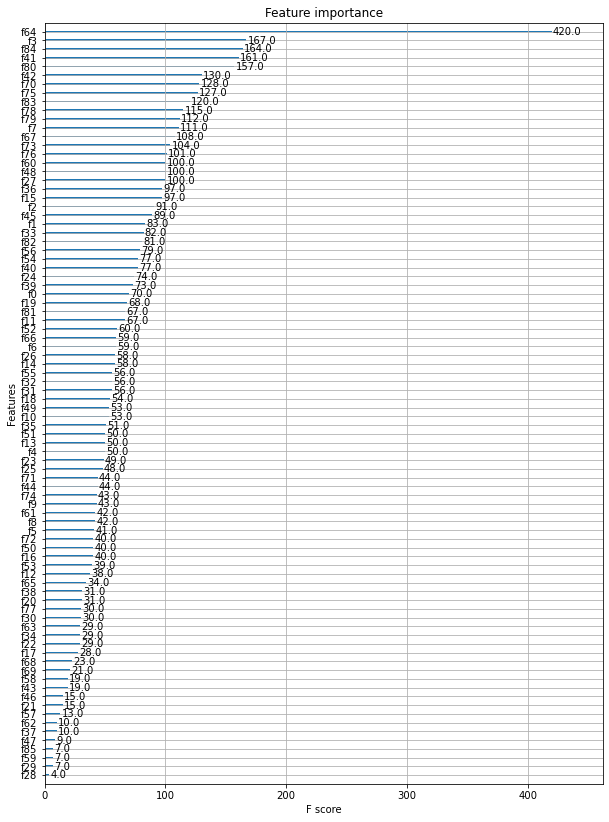

In [33]:
plot_features_importance(model, (10,14))

#### З графіку важливості фіч можна зробити наступні висновки: 
1. Модель сильно враховує різницю у витраті кристалів між днями. Сенс цієї фічі полягає в тому, що вона дає моделі інформацію про різницю кристалів між двома днями. Таким чином, знаючи різницю кристалів наприклад між 7 та 3 днем, ми можемо робити зробити деякий висновок про те який прибуток людина принесла. Якщо різниця кристалів між днями достатньо велика, то можна зробити висновок, що людина купила ці кристали за реальні гроші і завдяки чому принесла прибуток. А якщо різниця невелика, то можна зробити висновок, що людина не придбала ці кристали за реальні гроші, а заробила їх за внутрішньоігрові активності. Можливе покращення для моделі: додати більше можливих інтеракцій з витраченими за дні кристали
2. Кількість сесій в певний день. Це показник може сказати про активність людини. Таким чином дійсно зацікавлені люди мають великий потенціал щодо принесення прибутку. Також можна створити деякі розумні інтеракції з кількістью сесій гравця.
3. Відношення витрачених кристалів до прибутку за купівлю кристалів та тікетів та навпаки. Це відношення підсказує моделі наскільки людина має здатність купувати кристали / тікети за реальні гроші, приносячи прибуток, а не заробляючи ці валюти за внутрішньоігрові активності. Можливе покращення: спробувати аналогії з тікетами.
4. Аналогічно до пункту №1, модель враховує різницю у витраті тікетів між днями.
5. Кількість закінчених / закритих / відкритих глав. Аналогічно до пункту №2, ці фічі показують також показують активність та зацікавленість гравця.
6. Природньо модель також враховує кумулятивні фічі з прибутку за купівлю кристалів, тікетів, підписок та реклами. Також різниця між днями цих фіч допомогає моделі дізнаватися про різницю цих доходів та робити деякі висновки про загальний цільовий прибуток. Наприклад різниця між днями кумулятивної доходності за купівлю кристалів та тікетів дає розуміння скільки людина принесла прибутку за деякий проміжок часу. 
Та інші взаємодії різних фіч на основі вищезазначених пунктів. 
Варто ще сказати, те що є деякі нереалізовані фічі, які на нашу думку ще можна було б якось розумно використати. Можна зробити деякі інтеракції та нові фічі з поверненням людей у конкретний день, про платформу користувача, про країну. Наприклад якщо були б більше інформації про тип пристрою, то можна припустити, що гравці з більш флагманськими пристроями потенційно принесуть більше доходу ніж ті гравці з відносно бюджетними пристроями. Також розташування гравця теж може грати роль, адже гравці з розвинутих країн більш схильні до принесення прибутку через економічну забезпеченість. Всі ці ідеї можна використати для покращення точності прогнозу. 

In [34]:
# Експорт моделі
joblib.dump(model, "model.sav")

['model.sav']

P.S.: Ми фанати My Fantasy: Choose Your Story && My Fantasy: Choose Romance